In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Sep  6 16:43:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

# Collaborative Filtering

## First, load the data and apply preprocessing

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown https://drive.google.com/uc?id=1dFuCcqIO0_vQcNg_47Ondz3akBG1ojzb

Downloading...
From: https://drive.google.com/uc?id=1dFuCcqIO0_vQcNg_47Ondz3akBG1ojzb
To: /content/ratings_Electronics.csv
100% 319M/319M [00:02<00:00, 110MB/s]


In [ ]:
g=pd.read_csv('ratings_Electronics.csv')

In [ ]:
rating_df =pd.read_csv('ratings_Electronics.csv',  names=['userID','itemID','rating','time'])
rating_df=rating_df[['userID','itemID','rating','time']]



In [ ]:
rating_df.dropna(inplace=True)

In [ ]:
x = rating_df.groupby('itemID').count()['rating'] > 30
itemIndex = x[x].index
nm_rating_df=rating_df[rating_df['itemID'].isin(itemIndex)]
y = nm_rating_df.groupby('userID').count()['rating']>=30
users = y[y].index
final_ratings = nm_rating_df[nm_rating_df['userID'].isin(users)]
rating_df=final_ratings

In [ ]:
user_ids = rating_df["userID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
item_ids = rating_df["itemID"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
rating_df["userID"] = rating_df["userID"].map(user2user_encoded)
rating_df["itemID"] = rating_df["itemID"].map(item2item_encoded)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
rating_df['userID']=rating_df['userID'].astype(int)
rating_df['itemID']=rating_df['itemID'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
final_ratings=rating_df.sort_values(by=['userID','time'], ascending=[False,False]) 
final_ratings.shape

(128798, 4)

In [ ]:
test_df=final_ratings.groupby('userID').head(5)
test_df.shape

(13210, 4)

In [ ]:
rating_df=rating_df[~rating_df.isin(test_df).all(1)]
final_ratings.shape

(128798, 4)

removing any items from test which does not present in train

In [ ]:
itemsintrain=list(rating_df.itemID.unique())
test_df=test_df[test_df.itemID.isin(itemsintrain)]

In [ ]:
item_df=pd.DataFrame (itemsintrain, columns = ['itemID'])

First, need to perform some preprocessing to encode users and movies as integer indices.

In [ ]:


num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
rating_df["rating"] = rating_df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])

print(
    "Number of users: {}, Number of items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)

Number of users: 2642, Number of items: 25739, Min rating: 1.0, Max rating: 5.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Prepare training and validation data

In [ ]:
df = rating_df.sample(frac=1, random_state=42)
x = df[["userID", "itemID"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

Create Model

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.item_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.item_bias = layers.Embedding(num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

## Train the model based on the data split

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/20
813/813 [==============================] - 9s 5ms/step - loss: 0.5867 - val_loss: 0.4709
Epoch 2/20
813/813 [==============================] - 4s 5ms/step - loss: 0.4698 - val_loss: 0.5735
Epoch 3/20
813/813 [==============================] - 4s 5ms/step - loss: 0.4541 - val_loss: 0.5171
Epoch 4/20
813/813 [==============================] - 4s 5ms/step - loss: 0.4470 - val_loss: 0.5327
Epoch 5/20
813/813 [==============================] - 4s 5ms/step - loss: 0.4423 - val_loss: 0.5108
Epoch 6/20
813/813 [==============================] - 4s 5ms/step - loss: 0.4425 - val_loss: 0.5150
Epoch 7/20
813/813 [==============================] - 4s 5ms/step - loss: 0.4480 - val_loss: 0.5130
Epoch 8/20
813/813 [==============================] - 4s 5ms/step - loss: 0.4574 - val_loss: 0.5269
Epoch 9/20
813/813 [==============================] - 4s 5ms/step - loss: 0.4685 - val_loss: 0.4856
Epoch 10/20
813/813 [==============================] - 4s 5ms/step - loss: 0.4762 - val_loss: 0.5190

## Plot training and validation loss

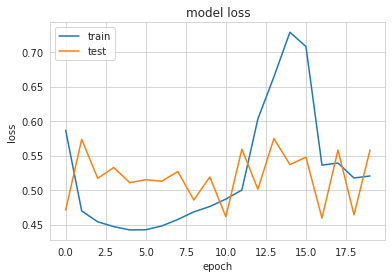

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Show top 10 movie recommendations to a user

In [ ]:
unoque_uesrs=list(rating_df.userID.unique())

In [ ]:

totalhit=0
totaliteration=0
for i in range(len(unoque_uesrs)):
    totaliteration+=1
    item_df['itemID']=item_df.itemID.astype(int)
    items = list(item_df.itemID.unique())

    # Let us get a user and see the top recommendations.
    user_id = rating_df.userID.values[i]
    items_rated_by_user = rating_df[rating_df.userID == user_id]


    items_not_rated = item_df[
        ~item_df["itemID"].isin(list(items_rated_by_user.itemID.values))
    ]["itemID"]
    items_not_rated=list(items_not_rated)

    user_encoder=user_id
    user_encoder=[[user_encoder]] * len(items_not_rated)
    items_not_rated = np.array(items_not_rated).reshape(len(items_not_rated),1)
    user_item_array = np.hstack(
        (user_encoder, items_not_rated)
    )

    ratings = model.predict(user_item_array).flatten()

    recommendation = pd.DataFrame({'user': user_item_array[:, 0], 'item': user_item_array[:, 1]})
    recommendation['rating']=list(ratings)
    top_ratings_indices = ratings.argsort()[-20:][::-1]
    recommended_item_ids = [
        x for x in top_ratings_indices
    ]

    top_items_user =list (
        recommendation.sort_values(by="rating", ascending=False)
        .head(20)
        .item.values
    )

    #top_items_user
    tmp_df=test_df[test_df['userID']==user_id]
    hitcount=list(tmp_df[tmp_df['itemID'].isin(top_items_user)].itemID.values)

    hitcount=len(hitcount)/len(top_items_user)
    totalhit+=hitcount

In [ ]:
print("precision: "+str(totalhit/totaliteration))